In [1]:
# Libraries
import pandas as pd
import numpy  as np
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.cluster       import KMeans
from sklearn.cluster       import AgglomerativeClustering
from sklearn.cluster       import DBSCAN
from sklearn.metrics       import accuracy_score
from sklearn.metrics       import confusion_matrix
from sklearn.metrics       import plot_confusion_matrix
from sklearn.decomposition import PCA

In [2]:
# local file paths
dir_name = 'preparazione'

fp_xtrain = dir_name + "/X_train.csv"
fp_ytrain = dir_name + "/y_train.csv"
fp_xval   = dir_name + "/X_val.csv"
fp_yval   = dir_name + "/y_val.csv"
fp_xtest  = dir_name + "/X_test.csv"
fp_ytest  = dir_name + "/y_test.csv"

In [3]:
# Reading dataframes
X_train = pd.read_csv(fp_xtrain, low_memory=False)
y_train = pd.read_csv(fp_ytrain, low_memory=False)
X_val   = pd.read_csv(fp_xval,   low_memory=False)
y_val   = pd.read_csv(fp_yval,   low_memory=False)
X_test  = pd.read_csv(fp_xtest,  low_memory=False)
y_test  = pd.read_csv(fp_ytest,  low_memory=False)

In [4]:
# Removes from the given dataframe the column with the given name
def remove_column(df, col_names):
    df.drop(col_names, axis=1, inplace=True)
    return df

In [5]:
for X in [X_train, X_val, X_test]:
    X = remove_column(X, ['parcelid'])

In [6]:
# Prints all dataframes shape
def dimensionality(y=False):
    print(f'X_train {  X_train.shape}')
    print(f'X_val   {    X_val.shape}')
    print(f'X_test  {   X_test.shape}')
    if y:
        print(f'y_train { y_train.shape}')
        print(f'y_val   {   y_val.shape}')
        print(f'y_test  {  y_test.shape}')

In [7]:
dimensionality(y=True)

X_train (99709, 72)
X_val   (33572, 72)
X_test  (33567, 72)
y_train (99709, 1)
y_val   (33572, 1)
y_test  (33567, 1)


In [8]:
print(*X_train.columns, sep='\n')

bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
calculatedfinishedsquarefeet
finishedsquarefeet12
fireplacecnt
latitude
longitude
lotsizesquarefeet
rawcensustractandblock
regionidcity
regionidzip
roomcnt
unitcnt
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
landtaxvaluedollarcnt
taxamount
int_transactiondate
period_mean_price
neighborhood_mean_price
living_area_prop
tax_ratio
tax_prop
buildingqualitytypeid_na_flag
unitcnt_na_flag
fips_6037.0
fips_6059.0
fips_6111.0
heatingorsystemtypeid_1.0
heatingorsystemtypeid_2.0
heatingorsystemtypeid_6.0
heatingorsystemtypeid_7.0
heatingorsystemtypeid_10.0
heatingorsystemtypeid_11.0
heatingorsystemtypeid_12.0
heatingorsystemtypeid_13.0
heatingorsystemtypeid_18.0
heatingorsystemtypeid_20.0
heatingorsystemtypeid_24.0
poolcnt_1.0
propertycountylandusecode_0100
propertycountylandusecode_0101
propertycountylandusecode_010C
propertycountylandusecode_122
propertycountylandusecode_34
propertycountylandusecode_rare
pro

In [9]:
regionids = ['regionidcounty_1286.0', 'regionidcounty_2061.0', 'regionidcounty_3101.0']

region_names = np.array(['A', 'B', 'C'])

## Clustering ##

In [10]:
# Returns a new dataframe X without region infos, which are returned in y vector in 0, 1, 2 encoding
def get_X_y(X):
    X_ = X.copy() 
    y_ = X_.loc[:, regionids]  
    y_.loc[:,['region']] =\
        y_.loc[:,regionids[0]] * 0 +\
        y_.loc[:,regionids[1]] * 1 +\
        y_.loc[:,regionids[2]] * 2
    X_ = remove_column(X_, regionids)
    y_ = remove_column(y_, regionids)
    y_ = y_.values.ravel().astype(np.int64)
    return X_, y_

Guardo se un algoritmo di clustering individua le tre differenti regioni

### k-means 

In [11]:
def kmeans_clustering(X):
    kmeans = KMeans(n_clusters=3, random_state=10).fit(X)
    print(kmeans.labels_)
    return kmeans, kmeans.labels_

### DBScan

In [12]:
# Validation clustering to tune EPS
def valid_dbscan_clustering(X):
    n_clu      = 1
    CLU_SEARCH = 3
    EPSMIN      = 1.
    EPSMAX      = 10.
    while(n_clu != CLU_SEARCH and EPSMIN < EPSMAX - 0.005):
        EPS = (EPSMIN + EPSMAX) / 2
        print(f'EPS: {EPS}, EPSMIN: {EPSMIN}, EPSMAX: {EPSMAX}, NCLU: {n_clu}')
        n_clu = valid_dbscan_clustering_aux(X, EPS)
        if n_clu < CLU_SEARCH:
            EPSMIN = EPS
        else:
            EPSMAX = EPS
    return EPS  

def valid_dbscan_clustering_aux(X, eps):
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=3, n_jobs=-1).fit(X)
    labels = db.labels_
    n_clu = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'EPS: {eps}, NCLU: {n_clu}')
    return n_clu

In [13]:
def dbscan_clustering(X, eps):
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=3, n_jobs=-1).fit(X)
    labels = db.labels_
    print(labels)
    print('N-Cluster: ', len(set(labels)) - (1 if -1 in labels else 0))
    print('Outliers:  ', list(labels).count(-1))
    return db, labels

<br><br>

In [14]:
# Given a vector and a mapping function returns the corresponding transormation
def transform(y, mapping):
    y_2 = map(mapping, y) 
    y_2 = np.array(list(y_2))
    return y_2

In [15]:
# Returns the accuracy score given actual values and predictions
def accuracy(y_true, y_pred, verbose = False):
    acc = accuracy_score(y_true, y_pred)
    if verbose:
        print(y_pred [:35])
        print(y_true [:35])
        print('Accuracy: ', acc)
    return acc

In [16]:
X_clu, y_true = get_X_y(X_train)

In [17]:
est, y_pred = kmeans_clustering(X_clu)

[1 1 1 ... 1 1 1]


In [18]:
print('True     ', y_true[:35],)
print('Predicted', y_pred[:35],)

True      [0 2 2 0 2 0 1 0 0 2 0 0 2 2 2 2 2 1 2 2 2 0 2 2 2 2 1 2 2 0 2 2 0 2 2]
Predicted [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [19]:
for i in range(3):
    print(f'Occorrenze Regione{region_names[i]} : {np.bincount(y_true)[i]}')
print()

for i in range(3):
    print(f'Occorrenze Cluster{i} : {np.bincount(y_pred)[i]}')

Occorrenze RegioneA : 26819
Occorrenze RegioneB : 8119
Occorrenze RegioneC : 64771

Occorrenze Cluster0 : 7662
Occorrenze Cluster1 : 91784
Occorrenze Cluster2 : 263


In [20]:
# Conversion RegionEncoding <--> ClusterEncoding
def get_lambda(to0, to1, to2):
    return lambda x: to0 if (x == 0) else (to1 if (x == 1) else to2)

In [21]:
l = get_lambda(0, 2, 1)

Da questa piccola anteprima sembra essere avvenuto il seguente mapping
0 -> 2
1 -> 0
2 -> 1

In [22]:
accuracy(
    y_true,
    transform(y_pred, l),
)

0.6242666158521297

In [23]:
cm = confusion_matrix(transform(y_true, l), y_pred)
cm

array([[ 2455, 24292,    72],
       [ 4794, 59788,   189],
       [  413,  7704,     2]])

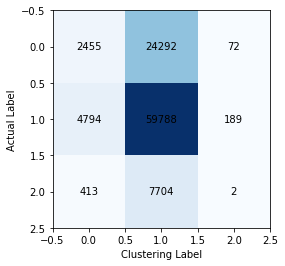

In [24]:
plt.imshow(cm, interpolation='none', cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("Clustering Label")
plt.ylabel("Actual Label")
plt.show()

## PCA ##

In [25]:
X_pca, y_pca = get_X_y(X_train)

In [26]:
y_pca

array([0, 2, 2, ..., 1, 0, 2])

In [27]:
for i in range(3):
    print(f'Occorrenze Regione{region_names[i]} : {np.bincount(y_pca)[i]}')

Occorrenze RegioneA : 26819
Occorrenze RegioneB : 8119
Occorrenze RegioneC : 64771


In [28]:
X_train.shape

(99709, 72)

In [29]:
X_pca.shape

(99709, 69)

In [30]:
y_pca.shape

(99709,)

In [31]:
pca = PCA(n_components=2)
X_pca_2 = pca.fit_transform(X_pca)

In [32]:
X_pca_2

array([[-429875.60737379, -453323.98434628],
       [-386758.35906053,  169659.45127891],
       [-297745.54983615,  -63444.94873702],
       ...,
       [ 144260.52944037,  697467.38392367],
       [ 117570.48987628, -439572.16432855],
       [-372775.08344991,  -98901.38691122]])

In [33]:
def plot_pca(X, y):
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(10,6))

    colors = np.array([
        (1., .1, .1, .3),
        (.1, 1., .1, .3),
        (.1, .1, 1., .3)]
    )

    # scatter is ismilar to plot, additionally a color per point is provided
    scatter = ax.scatter(X[:,0],X[:,1], c=colors[y], label=region_names[y])

    handles = []
    for c,l in zip(colors, region_names):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles)

    ax.set_xlabel("1st Component")
    ax.set_ylabel("2nd Component")
    ax.grid(linestyle=':', linewidth=.5)

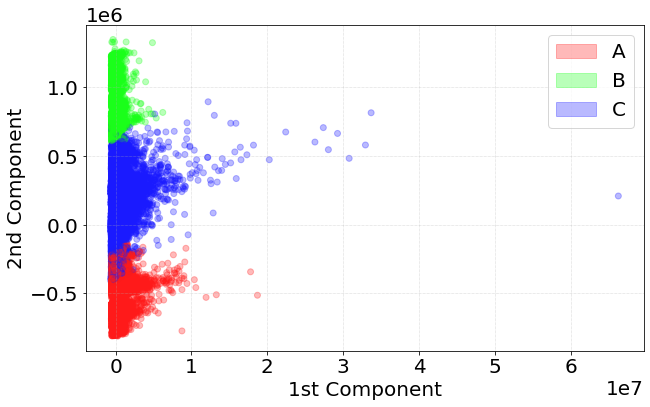

In [34]:
plot_pca(X_pca_2, y_pca)

# Split #

Divido il Dataset a seconda del region_id county

In [35]:
# Returns the X, y dataframes splitted throught regions
def split_regionid(X, y):
    A = X.loc[:,regionids[0]] == 1
    B = X.loc[:,regionids[1]] == 1 
    C = X.loc[:,regionids[2]] == 1    
    return X[A], X[B], X[C], y[A], y[B], y[C]

In [36]:
X_trainA, X_trainB, X_trainC, y_trainA, y_trainB, y_trainC = split_regionid(X_train, y_train)
X_valA,   X_valB,   X_valC,   y_valA,   y_valB,   y_valC   = split_regionid(X_val,   y_val  )
X_testA,  X_testB,  X_testC,  y_testA,  y_testB,  y_testC  = split_regionid(X_test,  y_test )

Mantengo i dataframe in un array

In [37]:
X_train = np.array([X_trainA, X_trainB, X_trainC], dtype=object)
X_val   = np.array([X_valA,   X_valB,   X_valC  ], dtype=object)
X_test  = np.array([X_testA,  X_testB,  X_testC ], dtype=object)
y_train = np.array([y_trainA, y_trainB, y_trainC], dtype=object)
y_val   = np.array([y_valA,   y_valB,   y_valC  ], dtype=object)
y_test  = np.array([y_testA,  y_testB,  y_testC ], dtype=object)

In [38]:
for X in [X_train, X_val, X_test]:
    for x in X:
        x = remove_column(x, regionids)

In [39]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [40]:
dimensionality(y=True)

X_trainA: (26819, 69)
X_valA:   (9006, 69)
X_testA:  (9085, 69)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 69)
X_valB:   (2658, 69)
X_testB:  (2606, 69)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 69)
X_valC:   (21908, 69)
X_testC:  (21876, 69)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



In [41]:
dir_name = 'regioni'

for i in range(3):
    X_train[i].to_csv( dir_name + f'/X_train{region_names[i]}.csv',  index=False)
    X_val  [i].to_csv( dir_name + f'/X_val{  region_names[i]}.csv',  index=False)
    X_test [i].to_csv( dir_name + f'/X_test{ region_names[i]}.csv',  index=False)
    y_train[i].to_csv( dir_name + f'/y_train{region_names[i]}.csv',  index=False)
    y_val  [i].to_csv( dir_name + f'/y_val{  region_names[i]}.csv',  index=False)
    y_test [i].to_csv( dir_name + f'/y_test{ region_names[i]}.csv',  index=False)    